# Continuum plots

Loads depth-frequency-time PSD data and then plots continuum for various analyses.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as pldates
import matplotlib.colors as colors
from scipy.stats import chi2
from scipy.optimize import curve_fit
for i in range(2):
    %matplotlib notebook

In [271]:
# import data

adcp = 'Axis55'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2018

ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')
n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [272]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')     # get GM data from separate code
gm_freq = np.asarray(gm[157:223,0])/(2*np.pi)       # GM frequency range
gm_psd = np.asarray(gm[157:223,1])*(np.pi)          # 1/2 GM amplitudes
gmpw = gm_psd * (gm_freq**2)                        # whiten
gmp_avg = np.nanmean(gmpw)                          # GM 'c' value.
print('1/2 GM amplitude:',gmp_avg)

1/2 GM amplitude: 8.242502888738867e-09


## Continuum fits (a, b)

In [ ]:
# select time range

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp_list,phi_u_temp,phi_v_temp = [],[],[]
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect_c.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_temp_list.append(ds[i].spect_c[j].values)
            phi_u_temp.append(ds[i].Sxxu_c[:,:,j])                 # time segment, [depth, freq]
            phi_v_temp.append(ds[i].Sxxv_c[:,:,j])
    dt_list.append(dt_temp_list)
    phi_u.append(phi_u_temp)
    phi_v.append(phi_v_temp)
print("Output time range:",dt_list[0][0],'to',dt_list[-1][-1])     # print to check desired interval

In [ ]:
# WKB scale and select depth

WKB_u,WKB_v = [],[]

for i in range(n_seg):
    WKB_u_test,WKB_v_test = [],[]
    for j in range(len(phi_u[i])):
        WKB_u_test.append(phi_u[i][j] / ds[0].WKB_scale)
        WKB_v_test.append(phi_v[i][j] / ds[0].WKB_scale)
    WKB_u.append(WKB_u_test)
    WKB_v.append(WKB_v_test)
    
didx = -1                   # -1 for lower depth, -20 for mid-depth
if adcp == 'Slope':
    didx = didx           # -1 for lower depth, -20 for mid-depth
elif adcp == 'Axis75':
    didx = didx           # -1 for lower depth, -19 for mid-depth
elif adcp == 'Axis55':
    didx = didx           # -1 for lower depth, -8 for mid-depth

u,v,time = [],[],[]
for i in range(n_seg):
    u_test,v_test,time_test = [],[],[]
    for j in range(len(phi_u[i])):
        u_test.append(WKB_u[i][j][didx,:].values)        
        v_test.append(WKB_v[i][j][didx,:].values)
        time_test.append(WKB_u[i][j].spect_c.values)
    u.append(u_test)
    v.append(v_test)
    time.append(time_test)
    
d_stamp = ds[0].depth[didx].values
print('Depth:',-d_stamp,'m')

In [ ]:
# continuum fits (6e-5 to 1e-4 Hz)

lowf = 55                    # set frequency range for continuum
highf = 94

f_range = frequencies[lowf:highf]      # set data range for continuum

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

ua,ub,va,vb = [],[],[],[]
u_c,v_c = [],[]

for i in range(n_seg):
    ua_temp,ub_temp,va_temp,vb_temp = [],[],[],[]
    u_range,v_range = [],[]
    for j in range(len(u[i])):
        u_range_temp = u[i][j][lowf:highf]
        v_range_temp = v[i][j][lowf:highf]

        # Fit the power-law data
        upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range_temp, p0=[1e-8, -2], bounds=([0,-5],[1,0]),maxfev=1000)
        vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range_temp, p0=[1e-8, -2], bounds=([1e-17,-5],[1e-3,0]),maxfev=1000)

        # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
        #ustdevs = np.sqrt(np.diag(ucov))
        #vstdevs = np.sqrt(np.diag(vcov))

        # Calculate the residuals
        #ures = u_range - power_law(f_range, *upars)
        #vres = v_range - power_law(f_range, *vpars)
        
        ua_temp.append(upars[0])       # get a and b coefficients
        ub_temp.append(upars[1])
        va_temp.append(vpars[0])
        vb_temp.append(vpars[1])
        u_range.append(u_range_temp)
        v_range.append(v_range_temp)
    
    ua.append(ua_temp)       # get a and b coefficients
    ub.append(ub_temp)
    va.append(va_temp)
    vb.append(vb_temp)
    u_c.append(u_range)
    v_c.append(v_range)

In [ ]:
# plot a values

fig,ax = plt.subplots(1,1,figsize=(12,4.6))

ax.set_title(fr'Power law ($af^b$) amplitudes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$a$',fontsize=14)  # (m/s)^2 ???
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            ax.plot(time[i],ua[i],label='Cross-slope',color='tab:blue')
            ax.plot(time[i],va[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ua[i],label='Cross-canyon',color='tab:blue')
            ax.plot(time[i],va[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            ax.plot(time[i],ua[i],color='tab:blue')
            ax.plot(time[i],va[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ua[i],color='tab:blue')
            ax.plot(time[i],va[i],color='tab:orange')

ax.set_yscale('log')
ax.set_xlim(start_date,end_date)
ax.set_ylim(1e-18,1e-0)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend(fontsize=14,loc='lower right',frameon=False)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_a_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# plot b values

fig,ax = plt.subplots(1,1,figsize=(12,4.6))

ax.set_title(fr'Power law ($af^b$) slopes - {adcp} (-{d_stamp} m) - {year}',fontsize=14)
ax.set_xlabel('Time [months]',fontsize=14)
ax.set_ylabel(r'$b$',fontsize=14)
ax.tick_params(labelsize=14)

for i in range(n_seg):
    if i == 0:
        if adcp == 'Slope':
            ax.plot(time[i],ub[i],label='Cross-slope',color='tab:blue')
            ax.plot(time[i],vb[i],label='Along-slope',color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ub[i],label='Cross-canyon',color='tab:blue')
            ax.plot(time[i],vb[i],label='Along-canyon',color='tab:orange')
    elif i > 0:
        if adcp == 'Slope':
            ax.plot(time[i],ub[i],color='tab:blue')
            ax.plot(time[i],vb[i],color='tab:orange')
        elif adcp == 'Axis75' or adcp == 'Axis55':
            ax.plot(time[i],ub[i],color='tab:blue')
            ax.plot(time[i],vb[i],color='tab:orange')
            
ax.set_xlim(start_date,end_date)
ax.set_ylim(-4.5,0)
date_form = pldates.DateFormatter("%m")
ax.xaxis.set_major_formatter(date_form)

plt.legend(fontsize=14,loc='lower right',frameon=False)
plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_b_{adcp}_{t_stamp}.pdf',format='pdf')

## Get c amplitudes vs GM

In [273]:
# revise plotting variables

frequencies = ds[0].specf.values
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

In [274]:
# select time range

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp_list,phi_u_temp,phi_v_temp = [],[],[]
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_temp_list.append(ds[i].spect[j].values)
            phi_u_temp.append(ds[i].Sxxu[:,:,j])                   # time segment, [depth, freq]
            phi_v_temp.append(ds[i].Sxxv[:,:,j])
    dt_list.append(dt_temp_list)
    phi_u.append(phi_u_temp)
    phi_v.append(phi_v_temp)
print("Output time range:",dt_list[0][0],'to',dt_list[-1][-1])     # print to check desired interval

Output time range: 2018-01-06T08:07:30.000000000 to 2018-12-15T00:37:29.000000000


In [275]:
# WKB scale

WKB_u,WKB_v = [],[]

for i in range(n_seg):
    WKB_u_test,WKB_v_test = [],[]
    for j in range(len(phi_u[i])):
        WKB_u_test.append(phi_u[i][j] / ds[0].WKB_scale)
        WKB_v_test.append(phi_v[i][j] / ds[0].WKB_scale)
    WKB_u.append(WKB_u_test)
    WKB_v.append(WKB_v_test)

In [276]:
# loop through depth    

# specify continuum range

lowf = 55                    # set frequency range for continuum
highf = 94

f_range = frequencies[lowf:highf]      # set data range for continuum

u_ts,v_ts,time = [],[],[]
for d in range(len(depth)):

    u,v,time_t = [],[],[]
    for i in range(n_seg):
        u_test,v_test,time_test = [],[],[]
        for j in range(len(phi_u[i])):
            u_test.append(WKB_u[i][j][d,:].values)        
            v_test.append(WKB_v[i][j][d,:].values)
            time_test.append(WKB_u[i][j].spect.values)
        u.append(u_test)
        v.append(v_test)
        time_t.append(time_test)

    u_c,v_c = [],[]

    for i in range(n_seg):
        u_range,v_range = [],[]
        for j in range(len(u[i])):
            u_range_temp = u[i][j][lowf:highf]
            v_range_temp = v[i][j][lowf:highf]
            u_range.append(u_range_temp)
            v_range.append(v_range_temp) 
        u_c.append(u_range)
        v_c.append(v_range)

    # whiten and take average

    u_c_avg, v_c_avg = [],[]
    for i in range(n_seg):
        u_c_w_t,v_c_w_t = [],[]
        for j in range(len(u_c[i])):
            uw = u_c[i][j] * (f_range**2)
            vw = v_c[i][j] * (f_range**2)
            u_c_w_t.append(np.nanmean(uw))
            v_c_w_t.append(np.nanmean(vw))
        u_c_avg.append(u_c_w_t)
        v_c_avg.append(v_c_w_t)
        
    u_ts.append(u_c_avg)
    v_ts.append(v_c_avg)
    time.append(time_t)
    
# depth, n_seg, time
print('Freq. range:',f_range[0],'to',f_range[-1],'Hz')

<ipython-input-276-8b889f6af92d>:44: RuntimeWarning: Mean of empty slice
  u_c_w_t.append(np.nanmean(uw))
<ipython-input-276-8b889f6af92d>:45: RuntimeWarning: Mean of empty slice
  v_c_w_t.append(np.nanmean(vw))


Freq. range: 5.9678222656250005e-05 to 0.00010091044921875 Hz


In [277]:
# reorganise for n_seg,depth,time

uts,vts,ts = [],[],[]
for i in range(n_seg):
    uts_temp,vts_temp,ts_temp = [],[],[]
    for d in range(len(depth)):
        uts_temp.append(u_ts[d][i])
        vts_temp.append(v_ts[d][i])
        ts_temp.append(time[d][i])
    uts.append(uts_temp)
    vts.append(vts_temp)
    ts.append(ts_temp[0])

In [278]:
# get GM comparison

uGM,vGM = [],[]
for i in range(n_seg):
    uGM.append(uts[i]/gmp_avg)
    vGM.append(vts[i]/gmp_avg)

<IPython.core.display.Javascript object>


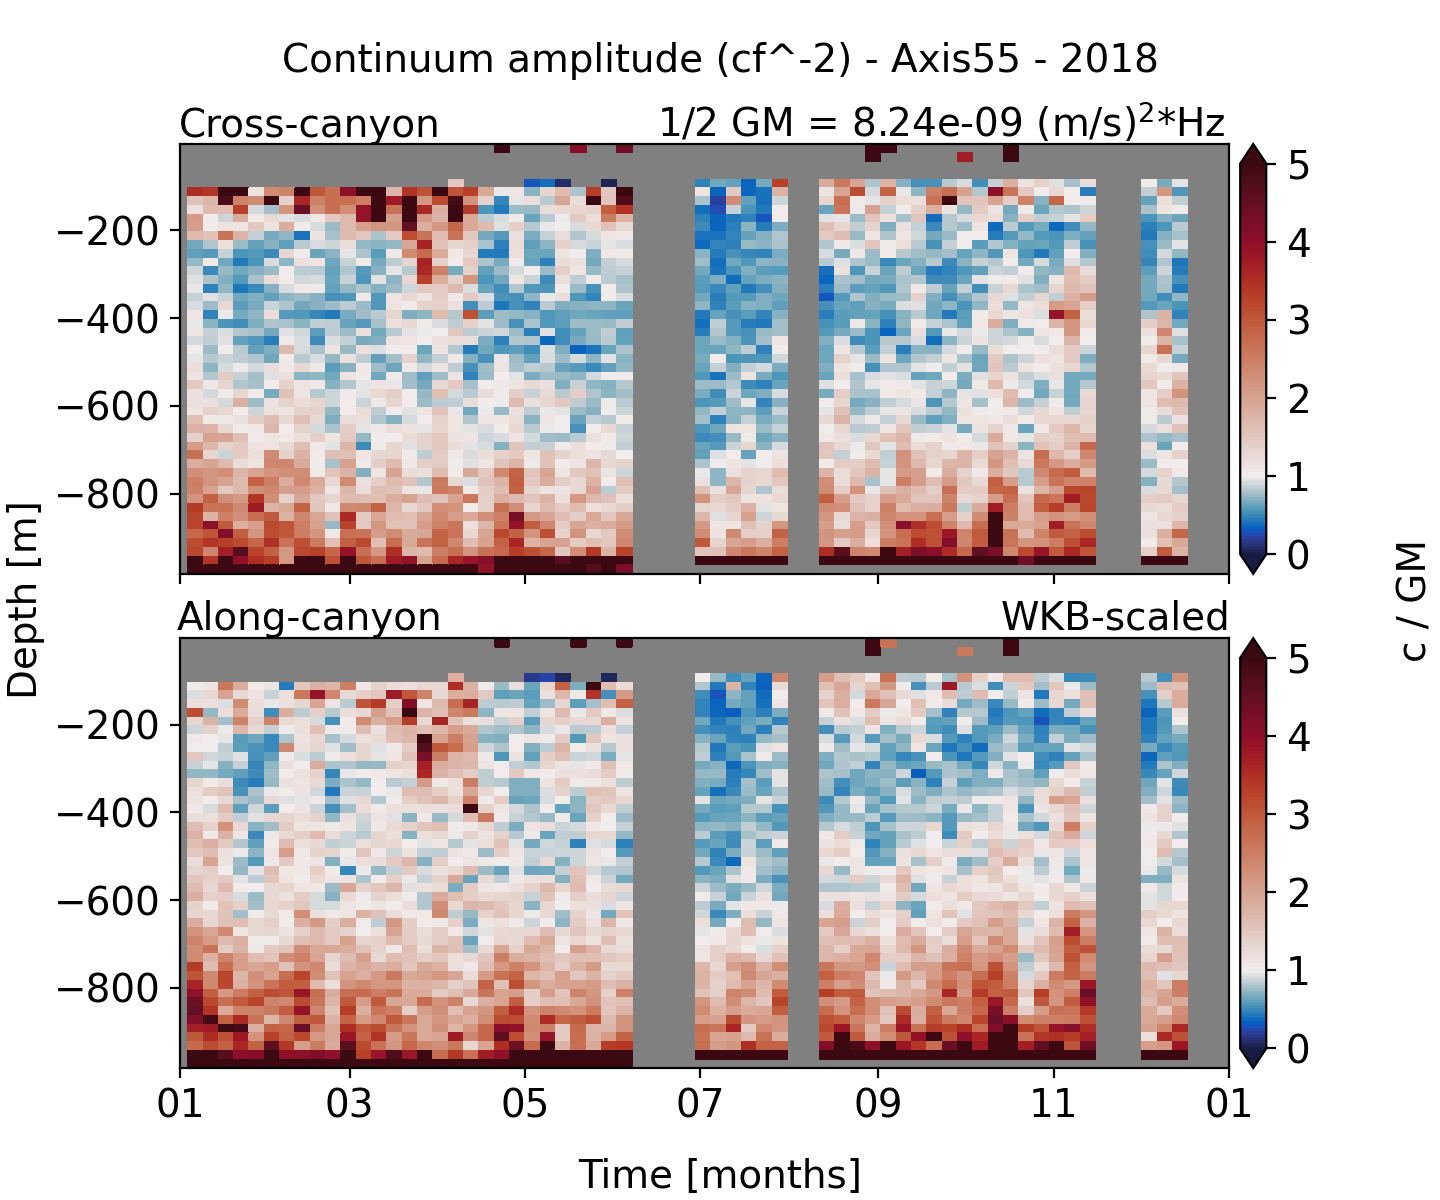

In [279]:
# plot c/GM ratio

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Continuum amplitude (cf^-2) - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, 'c / GM', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.695,0.475, 'WKB-scaled',fontsize=14)
fig.text(0.456,0.886, fr'1/2 GM = {gmp_avg:1.2e} (m/s)$^2$*Hz',fontsize=14)

if adcp == 'Slope':
    vmin = 0
    vmax = 3.5
    fig.text(0.205, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.205, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 0
    vmax = 5
    fig.text(0.215, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.215, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 0
    vmax = 5
    fig.text(0.215, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.215, 0.475, 'Along-canyon', ha='center',fontsize=14)

norm = colors.TwoSlopeNorm(vmin=vmin,vcenter=1,vmax=vmax)
for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, uGM[i], rasterized=True,cmap='cmo.balance',norm=norm,shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, vGM[i], rasterized=True,cmap='cmo.balance',norm=norm,shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_cGM_{adcp}_{t_stamp}.pdf',format='pdf')

## Dissipation estimates

In [280]:
# dissipation (Althaus et al., 2003)

eps0 = 4.1e-11           # [W/kg]
N0 = 5.24e-3             # GM reference buoyancy [rad/s]
N = 2.53e-3              # local WKB reference buoyancy [rad/s]
cor = 1.09e-4            # local Coriolis parameter [rad/s]
wM2 = 1.41e-4            # semidiurnal frequency [rad/s]
Rw = 2.13                # cannonical depth-average semidiurnal shear/strain ratio (Kunze et al., 2002)

fRw = (((Rw + 1) / Rw)**2) * ( np.arccosh(N / cor) + ((25 * np.arccos(cor / N)) / np.sqrt(Rw)))   # dimensionless upper bound

eps_u,eps_v,eps_tot = [],[],[]
for i in range(n_seg):
    eps_u_temp = eps0 * ((N**2) / (N0**2)) * (uGM[i]**2) * fRw       # dissipation rates [W / kg]
    eps_u.append(eps_u_temp)
    eps_v_temp = eps0 * ((N**2) / (N0**2)) * (vGM[i]**2) * fRw       # dissipation rates [W / kg]
    eps_v.append(eps_v_temp)
    eps_tot_temp = (eps_u_temp/2)+(eps_v_temp/2)
    eps_tot.append(eps_tot_temp)

<IPython.core.display.Javascript object>


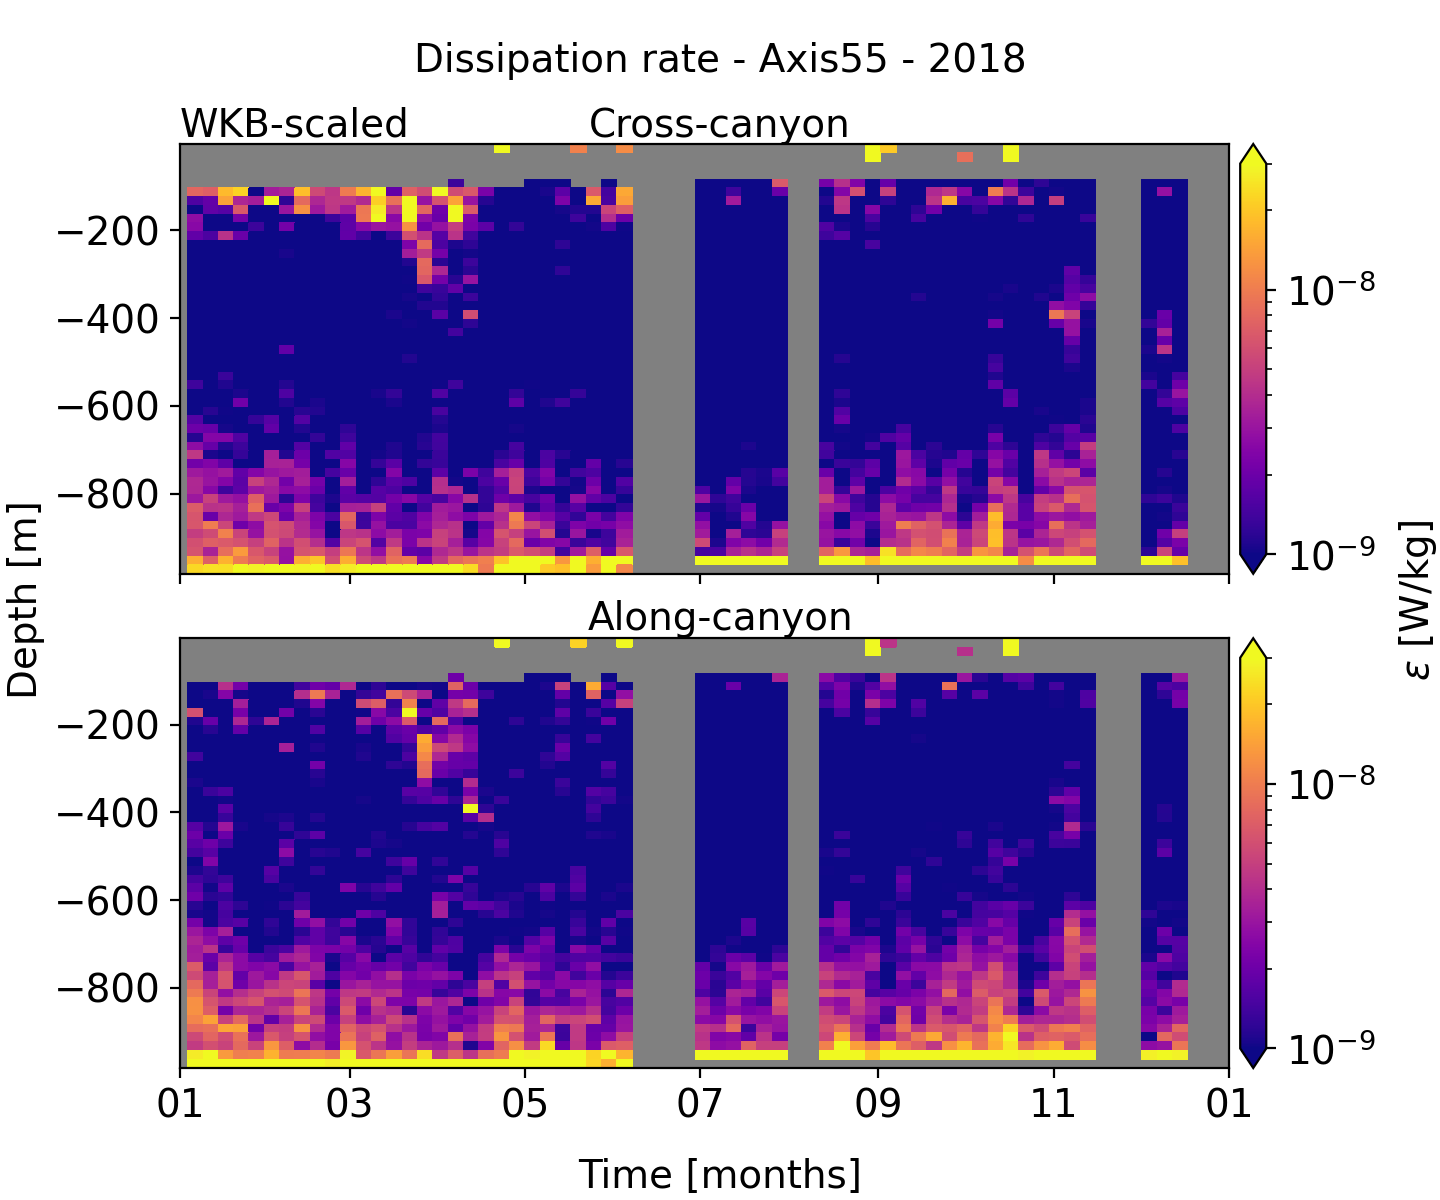

In [281]:
# plot dissipation estimates

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Dissipation rate - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, r'$\epsilon$ [W/kg]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 1e-9
    vmax = 4e-8
    fig.text(0.5, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 1e-9
    vmax = 3e-8
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, eps_u[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, eps_v[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_diss_{adcp}_{t_stamp}.pdf',format='pdf')

## Turbulent eddy diffusivities

In [282]:
# diffusivities (Kunze et al., 2002)

gamma = 0.2       # canonical mixing efficiency
N2 = N**2

kappa_u, kappa_v , kappa_tot = [],[],[]
for i in range(n_seg):
    kappa_u_temp = (gamma * eps_u[i]) / N2
    kappa_u.append(kappa_u_temp)
    kappa_v_temp = (gamma * eps_v[i]) / N2
    kappa_v.append(kappa_v_temp)
    kappa_tot_temp = (kappa_u_temp/2)+(kappa_v_temp/2)
    kappa_tot.append(kappa_tot_temp)

<IPython.core.display.Javascript object>


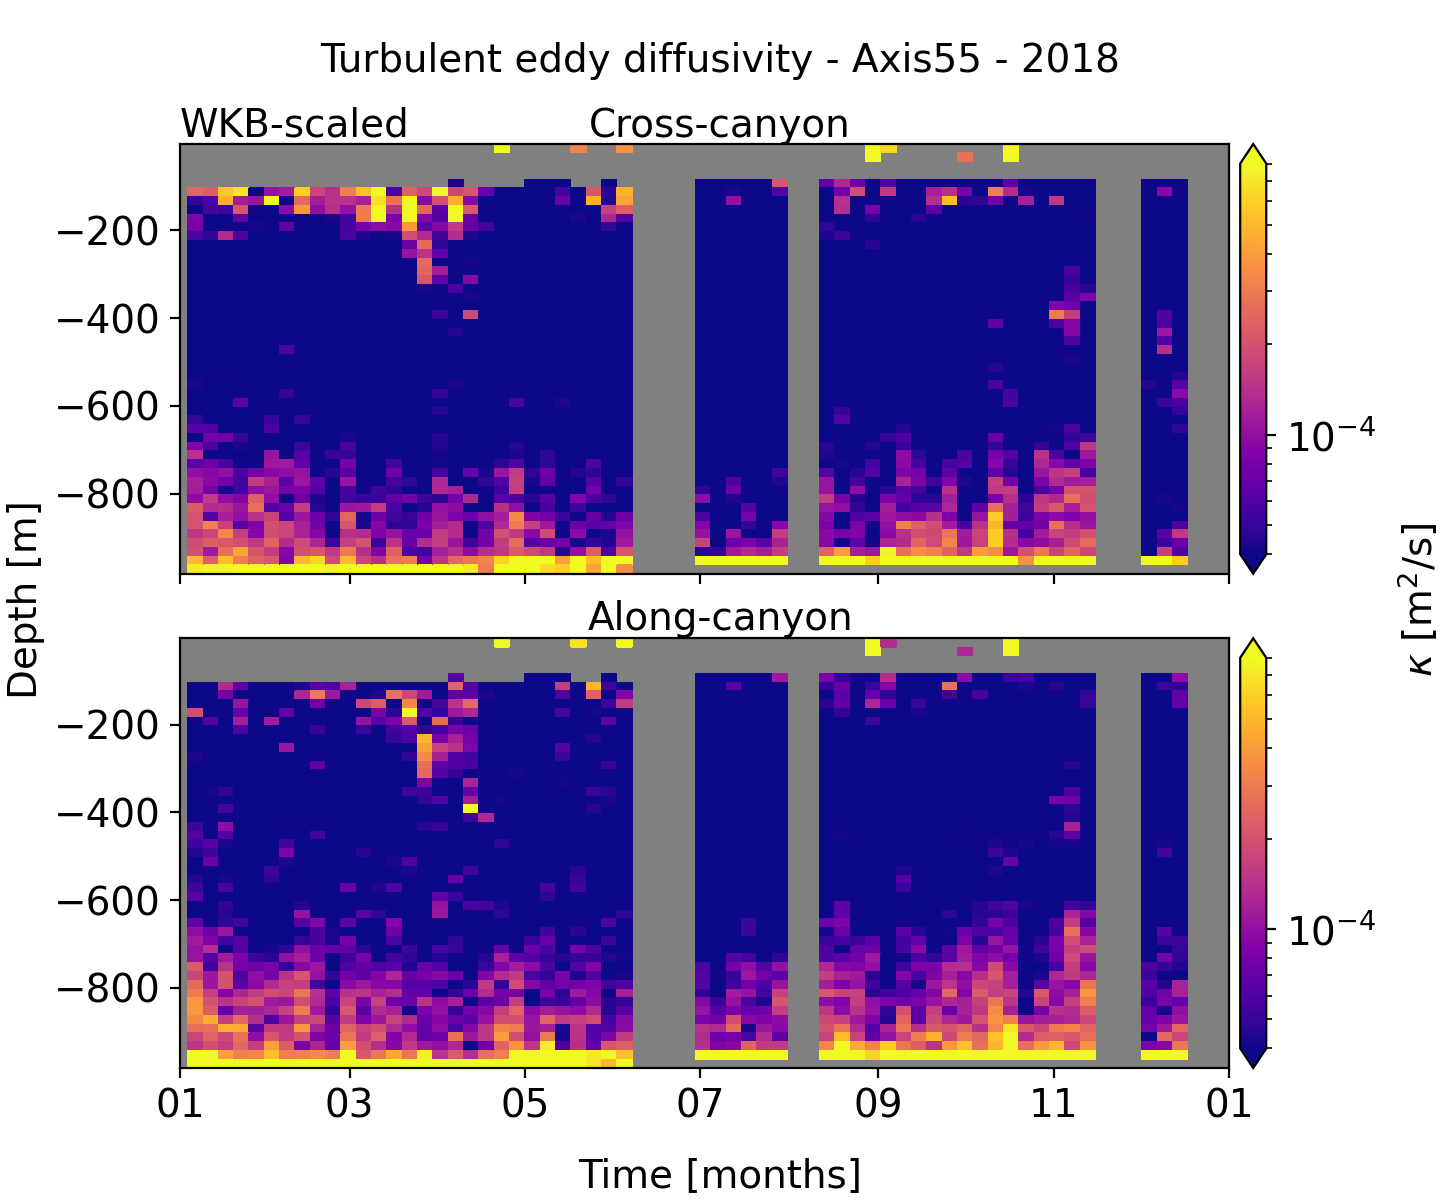

In [283]:
# plot diffusivities

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'Turbulent eddy diffusivity - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.5, r'$\kappa$ [m$^2$/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 3e-5
    vmax = 1e-3
    fig.text(0.5, 0.886, 'Cross-slope', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-slope', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 4e-5
    vmax = 8e-4
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 4e-5
    vmax = 8e-4
    fig.text(0.5, 0.886, 'Cross-canyon', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Along-canyon', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, kappa_u[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, kappa_v[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/cont_plots/cont_diff_{adcp}_{t_stamp}.pdf',format='pdf')

## Total plots

<IPython.core.display.Javascript object>


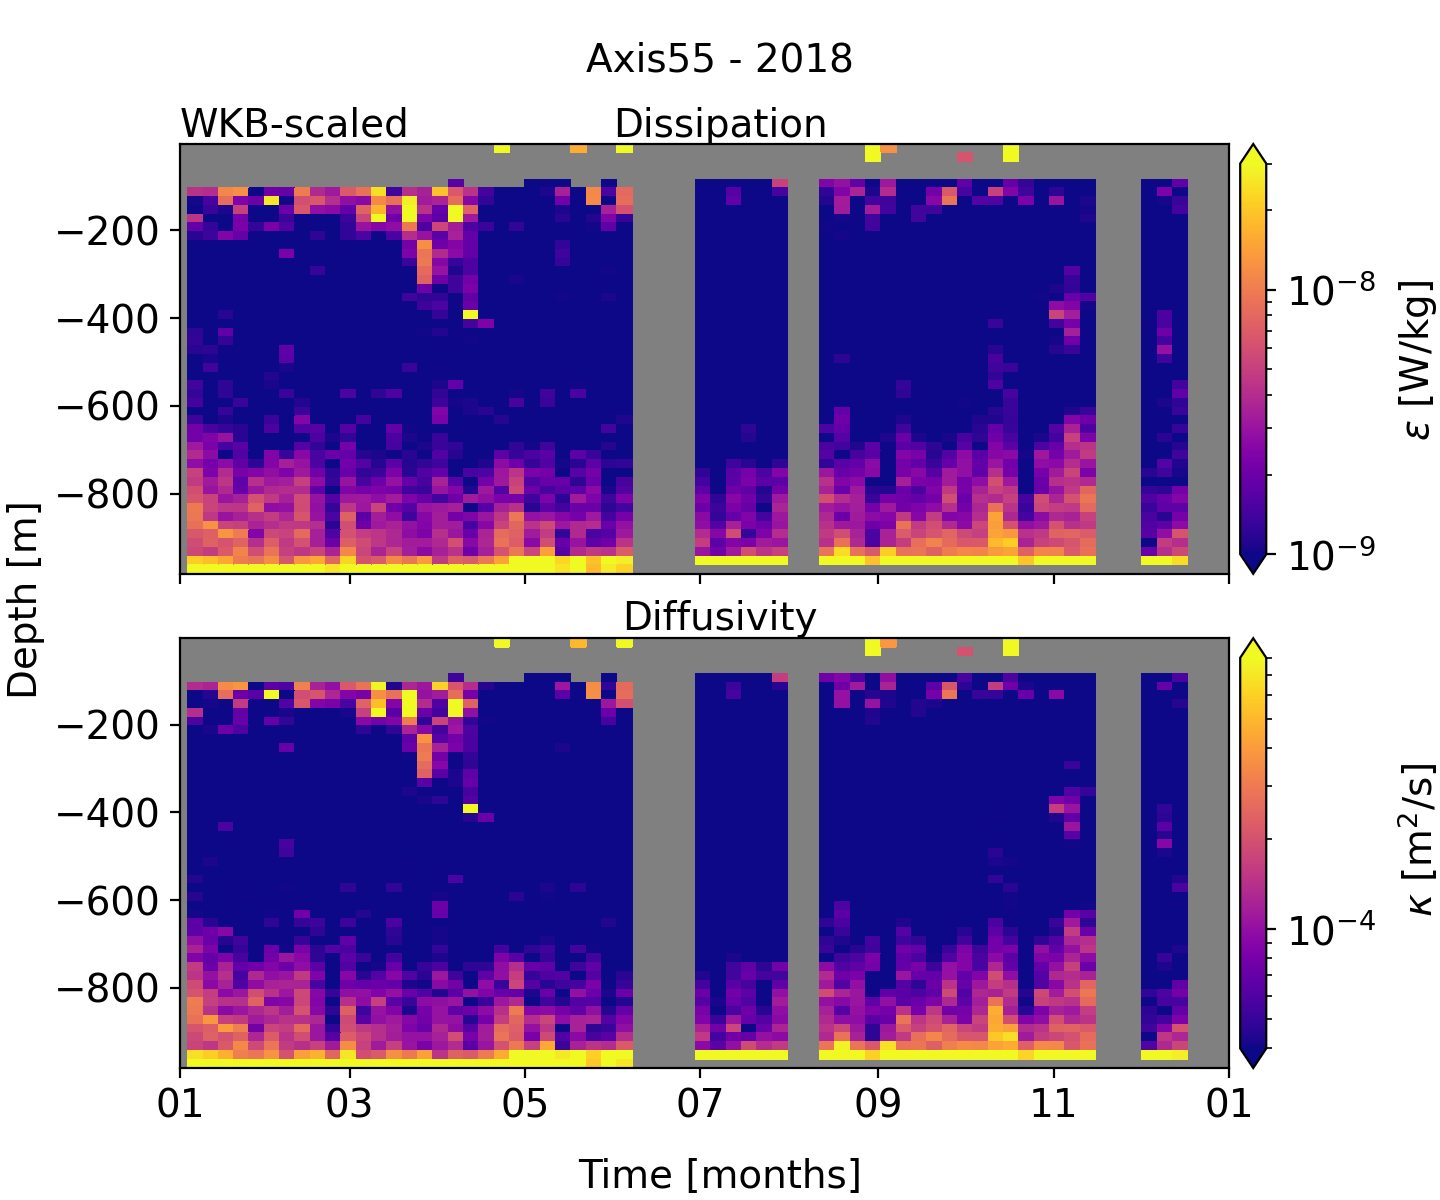

In [284]:
# plot diffusivities

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.3, r'$\kappa$ [m$^2$/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.7, r'$\epsilon$ [W/kg]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.125,0.886, 'WKB-scaled', fontsize=14)

if adcp == 'Slope':
    vmin = 1e-9
    vmax = 2e-8
    vmin1 = 2e-5
    vmax1 = 8e-4
    fig.text(0.5, 0.886, 'Dissipation', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Diffusivity', ha='center',fontsize=14)
elif adcp == 'Axis75':
    vmin = 1e-9
    vmax = 4e-8
    vmin1 = 4e-5
    vmax1 = 8e-4
    fig.text(0.5, 0.886, 'Dissipation', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Diffusivity', ha='center',fontsize=14)
elif adcp == 'Axis55':
    vmin = 1e-9
    vmax = 3e-8
    vmin1 = 4e-5
    vmax1 = 8e-4
    fig.text(0.5, 0.886, 'Dissipation', ha='center',fontsize=14)
    fig.text(0.5, 0.475, 'Diffusivity', ha='center',fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ts[i], -depth, eps_tot[i], rasterized=True,norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='plasma',shading='auto')  
    im1 = ax1.pcolormesh(ts[i], -depth, kappa_tot[i], rasterized=True,norm=colors.LogNorm(vmin=vmin1, vmax=vmax1),cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

#plt.savefig(fname=f'./plots/cont_plots/cont_tot_{adcp}_{t_stamp}.pdf',format='pdf')